## Conformally invariant dissipative relativistic fluid

Here we solve numerically the equations deduced in \ref{xxx}

In [1]:
using OrdinaryDiffEq
using Plots

We add the modules needed for the computation:

    choques_utils are the mp5 and kt shock capturing schemes
    
    Flux_functions_ext contain the fluxes and sources for the system
    
    inversion_ext the inversion between conservative and fluid quantities
    
The ext means that we are considering a vector of 10 variables, 5 conservative and 5 fluid variables. The fluid variables are evolved with a zero time derivative, and are updated inside the evolution equation using the inversion function.

In [2]:
include("choques_utils.jl") # all functions needed for evolution
include("Flux_function_ext.jl")
include("inversion_ext.jl")

 Activating environment at `~/Julia/Fluidos_Conformes/Conf_Fluids/Project.toml`
   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/Julia/Fluidos_Conformes/Conf_Fluids/Project.toml`
No Changes to `~/Julia/Fluidos_Conformes/Conf_Fluids/Manifest.toml`
┌ Info: Precompiling Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7]
└ @ Base loading.jl:1278


c_to_f_direct! (generic function with 1 method)

Some set of parameters:

p_1 χ = [- 1.; - 2.; - 10.] Speed = 1 dt/dx = 0.1

p_2 χ = [- 1.; - 2.; - 10.] Speed = 1 dt/dx = 0.01

p_3 χ = [- 1.; - 2.; - 10.] Speed = 10 dt/dx = 0.01

p_4 χ = [- 1.; - 0.5; - 200.] Speed = 1 dt/dx = 0.1

n_1 χ = [- 1.; 0.; - 1.] Speed = 1 dt/dx = 0.1

In [3]:
L=1. # Length of the integration region
M=400 # number of space-points in the discretization
t=1. # final time
dx = L/M
dt = 0.1 * dx # this depends on the maximal propagation speed
tol = 10^(-6) # error tolerance in inversion function (Newton-Raphson)
iter_max = 20  # maximum number of NR iterations
U=10 # number of fields (double the number of fields, one for fluid and the other for conservative quantities)
u_i=zeros(M*U) # flux variables for the initial data (these are used for the flux function)
du=zeros(M*U) # for the rhs
x = zeros(M) # the coordinates
χ = [- 1.0; - 0.0; - 1.0] # the equation parameters 
ξ = (49.735919716217296, 16.578639905405765) # (λ, κ) dissipative parameters
par_eq = (χ, ξ) # parameters to use on the equations
par_inv = (χ, tol, iter_max, U, M) # parameters for the inversion

([-1.0, -0.0, -1.0], 1.0000000000000004e-6, 20, 10, 400)

In [4]:
#full list of parameters for the evolution function
par = (par_eq, par_inv, 1. /dx, U, M, Flux, Speed_max, Is!, c_to_f!) 

(([-1.0, -0.0, -1.0], (49.735919716217296, 16.578639905405765)), ([-1.0, -0.0, -1.0], 1.0000000000000004e-6, 20, 10, 400), 400.0, 10, 400, Flux, Speed_max, Is!, c_to_f!)

In [5]:
# the initial data
#u0=zeros(M*U) # for the initial data U0=(Sx,Sy,By)
x0 = 0.4; x1 = 0.6

con_0 = view(reshape(u_i,(M,U)),:,1:U÷2)
flu_0 = view(reshape(u_i,(M,U)),:,U÷2+1:U)

for i in 1:M
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        flu_0[i,2] = 0.1 + 0.1 * (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 250                    #Sz
        flu_0[i,4] = -0.0 # * sin(pi*(x[i] - x0)/(x1-x0))^4 * sin(2*pi*(x[i] - x0)/(x1-x0))     #By
    else
        flu_0[i,2] = 0.1
    end
    
    flu_0[i,1] = -1.   #
    #flu_0[i,2] = flu_0[i,2] + 0.1  # v
    
end

f_to_c!(u_i, (χ, U, M)) # populate the conservative variables from the fluid ones
#f(du,u0,par,t);

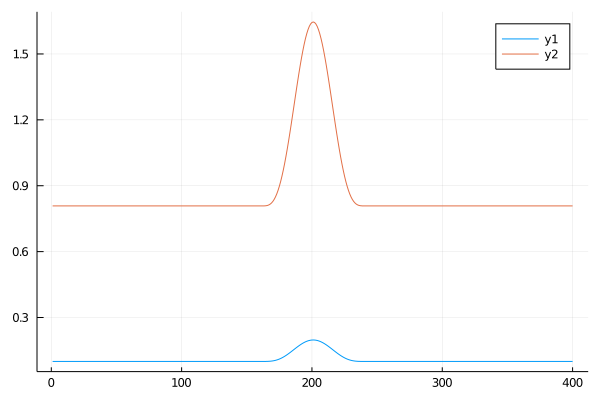

In [6]:
plot(flu_0[:,2])
plot!(con_0[:,2])

In [14]:
function evolution(du,u,par,t)
    # this is the function that is taken by the time-integrator
    par_eq, par_inv, h_1, U, M, Flux, Speed_max, Source, c_to_f = par
    χ, ζ = par_eq
    
    #p_direct = (χ, U, M) #these are the parameters for direct
    #c_to_f_direct!(u,p_direct)
    c_to_f!(u,par_inv)
    
    par_mp5 = (h_1, U, M, χ, ζ, Flux, Speed_max, Source)
    for j ∈ 1:M
        mp5(du,u,par_mp5,j)
    end
    return du[:]
end

evolution (generic function with 1 method)

In [15]:
prob = ODEProblem(evolution,u_i,(0.0,t),par);

In [ ]:
#sol_dir_n0 = solve(prob,SSPRK33(),dt=dt,saveat=0.01*t); # This, I think, is a TVD method
sol_nr_n0 = solve(prob,SSPRK33(),dt=dt,saveat=0.01*t); 
#sol = solve(prob,SSPRK33(),dt=dt,save_everystep=false) # to get just the end values
#sol = solve(prob,RK4(),dt=dt);

In [ ]:
#sol = sol_dir_n0;
sol = sol_nr_n0;

In [ ]:
field = 1
plot(reshape(sol(0.),(M,U))[:,field])
plot!(reshape(sol(t/8),(M,U))[:,field])
plot!(reshape(sol(t/4),(M,U))[:,field])
plot!(reshape(sol(t/2.1),(M,U))[:,field])
plot!(reshape(sol(t/1.1),(M,U))[:,field])

In [ ]:

anim = @animate for i ∈ 1:100
    plot(reshape(sol(t*0.01*i),(M,U))[:,5+1] .+ 1.,label="μ", yaxis = ("fluid", (-0.1,0.1)))
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+2] .- 0.1,label="v")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+3],label="X1")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+4],label="X2")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5+5],label="X3")
end

gif(anim, "ff_n0_nr_anim_fps10.gif", fps = 10)

In [ ]:

anim = @animate for i ∈ 1:100
    plot(reshape(sol(t*0.01*i),(M,U))[:,1] .- 6.085,label="e", yaxis = ("conserv", (-1,1)))
    plot!(reshape(sol(t*0.01*i),(M,U))[:,2] .- 0.8,label="s")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,3] .- 6,label="c1")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,4],label="c2")
    plot!(reshape(sol(t*0.01*i),(M,U))[:,5] .- 6.,label="c3")
end

gif(anim, "fc_n0_nr_anim_fps10.gif", fps = 10)

## Euler equations

We recuperate Euler's equations setting $\chi_1 = 0$ and the dissipative variables to zero. That way the systems decouple. And we get: (the notation here is a bit misleading,
here $\rho \approx e$ Different from $E = (\rho + p) = 4/3 \rho$, since $p = \frac{1}{3}\rho$ and so $s = Ev = 4/3 e v$

$F_e = \frac{4}{3}ργ^2v = s$

$F_s = \frac{4}{3}ρ(γ^2v^2 + \frac{1}{4}) = \frac{1}{3}ργ^2(4 v^2 + \frac{1}{\gamma^2} = 
\frac{1}{3}ργ^2(3v^2 + 1) $

$e = \frac{4}{3}ρ(γ^2 - \frac{1}{4}) = \frac{1}{3}ργ^2(4 - \frac{1}{\gamma^2}) = \frac{1}{3}ργ^2(3 + v^2)$

$s = \frac{4}{3}ργ^2v$

$4\frac{e}{s}v - (3 + v^2) = 0$

$v = 2\frac{e}{s} \pm \sqrt{4(\frac{e}{s})^2 -3}$

$v_- =  \frac{3}{2\frac{e}{s} + \sqrt{4(\frac{e}{s})^2 -3}} \approx \frac{3s}{4e}$
